In [3]:
%pip install seaborn plotly lightgbm scikit-learn Jinja2 nbformat

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/77.6 kB ? eta -:--:--
     --------------- ------------------------ 30.7/77.6 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 77.6/77.6 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/83.3 kB ? eta -:--:--
     ---------------------------------------- 83.3/83.3 kB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ---------------------------------------- 61.2/61.2 kB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/186.2 kB ? eta -:--:--
     ------------------------------------- 186.2/186.2 kB 11.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import warnings, gc
import numpy as np 
import pandas as pd

from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
from lightgbm import LGBMRanker
from decimal import ROUND_HALF_UP, Decimal

warnings.filterwarnings("ignore")

from gulf.dolphindb import BondDB
db = BondDB()


df0 = db.get_bond_daily_table_df(start_date='2023.01.01').dropna()

2023-10-20 22:37:41.950 | INFO     | gulf.dolphindb.base:__init__:32 - Connect to database 192.168.0.104:8848
2023-10-20 22:37:41.956 | INFO     | gulf.dolphindb.base:_create_table:100 - Partition table dfs://bond_daily_code/bond_daily_table exists, no need to create it.


The training data begins on 2023-01-04 00:00:00 and ends on 2023-10-20 00:00:00.



,open,high,low,close,volatile,volume,amount,pct_chg,vwap,bond_scale,trans_stock_premium,duallow,stock_cshare,stock_tshare,stock_nav
count,"92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00","92,054.00"
mean,130.46,131.77,129.29,130.37,2.48,"27,635,661.51","4,023,095,502.92",-0.01,133.35,17.02,0.43,130.80,"1,262,815,858.36","1,431,672,317.35",7.05
std,41.04,42.40,39.95,40.93,3.75,"138,022,395.77","23,042,703,367.03",1.39,44.02,43.97,0.40,40.91,"2,861,245,999.26","3,376,927,317.89",4.73
min,63.55,65.50,62.30,62.60,0.00,"1,960.00","207,758.53",-20.00,74.51,0.38,-0.48,62.54,"21,600,734.00","61,611,334.00",-2.83
25%,114.32,114.90,113.74,114.26,0.89,"135,940.00","16,574,135.71",-0.49,116.21,3.87,0.19,114.81,"211,294,371.00","278,146,280.00",4.03
50%,121.50,122.40,120.64,121.45,1.46,"1,096,785.00","162,077,531.69",-0.03,123.59,6.49,0.34,121.80,"487,026,120.00","534,357,822.00",5.85
75%,130.81,132.10,129.70,130.72,2.56,"16,578,750.00","2,055,167,066.59",0.41,134.86,14.00,0.56,131.02,"1,044,177,811.00","1,134,286,697.00",8.81
max,869.00,889.56,860.65,869.00,123.27,"7,889,056,000.00","1,166,455,816,318.00",20.00,773.28,499.99,3.46,869.04,"34,084,702,977.00","48,966,865,954.00",38.02


In [22]:
origin_df = df0.copy()

ml_target = 'ret'
open_pct_n = 1
sharp_window = 5

# TODO 注意这里一定不能用链式调用，否则会把其他标的的数据带入进来
origin_df[ml_target] = origin_df.groupby('jj_code').open.pct_change(open_pct_n) + 1
origin_df['cum_prod'] = (
    origin_df.groupby('jj_code')[ml_target]
    .rolling(sharp_window)
    .apply(lambda x: x.prod(), raw=True)
    .reset_index(drop=True)
) - 1
origin_df['std'] = (
    origin_df.groupby('jj_code')[ml_target]
    .rolling(sharp_window)
    # .apply(lambda x: x[np.where(x<1)].std(ddof=1) , raw=True)   # sharpe use x.std(), sortino use x[np.where(x<1)].std() 
    .apply(lambda x: x.std(ddof=1) , raw=True)   # sharpe use x.std(), sortino use x[np.where(x<1)].std() 
    .reset_index(drop=True)
)

origin_df['sharpe'] = (origin_df['cum_prod'] / origin_df['std']) ** (1/50)

origin_df[ml_target] = origin_df.groupby('jj_code')[ml_target].shift(-open_pct_n-1) - 1 # 注意target使用
origin_df['sharpe'] = origin_df.groupby('jj_code')['sharpe'].shift(-sharp_window-1) # 注意target使用


origin_df.drop(['cum_prod', 'std'], axis=1, inplace=True)
origin_df.dropna(inplace=True)
print(origin_df.columns)
origin_df

Index(['jj_code', 'bond_name', 'stock_name', 'trade_date', 'securityid',
       'open', 'high', 'low', 'close', 'volatile', 'volume', 'amount',
       'pct_chg', 'vwap', 'bond_scale', 'trans_stock_premium', 'duallow',
       'indclass', 'stock_cshare', 'stock_tshare', 'stock_nav', 'ret',
       'sharpe'],
      dtype='object')


,jj_code,bond_name,stock_name,trade_date,securityid,open,high,low,close,volatile,...,vwap,bond_scale,trans_stock_premium,duallow,indclass,stock_cshare,stock_tshare,stock_nav,ret,sharpe
2,SHSE.110043,无锡转债,无锡银行,2023-01-05,600908,114.200,115.050,114.020,114.600,1.030,...,113.351467,29.210,0.131415,114.731415,银行,1.866735e+09,2.151172e+09,8.407942,0.000000,0.997831
3,SHSE.110043,无锡转债,无锡银行,2023-01-06,600908,114.600,115.590,114.200,114.758,1.390,...,113.718594,29.210,0.145470,114.903470,银行,1.866735e+09,2.151172e+09,8.407942,-0.000785,1.011179
4,SHSE.110043,无锡转债,无锡银行,2023-01-09,600908,114.600,114.913,113.000,114.532,1.913,...,113.777772,29.210,0.160278,114.692278,银行,1.866735e+09,2.151172e+09,8.407942,-0.012645,1.037323
5,SHSE.110043,无锡转债,无锡银行,2023-01-10,600908,114.510,114.660,112.710,113.035,1.950,...,113.744796,29.210,0.149401,113.184401,银行,1.866735e+09,2.151172e+09,8.407942,0.006527,1.039742
6,SHSE.110043,无锡转债,无锡银行,2023-01-11,600908,113.062,114.278,113.062,113.539,1.216,...,113.728453,29.210,0.133303,113.672303,银行,1.866735e+09,2.151172e+09,8.407942,-0.001441,1.054441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92034,SZSE.128141,旺能转债,旺能环境,2023-01-06,002034,129.117,129.715,127.600,127.950,2.115,...,126.756298,12.701,0.055466,128.005466,环保行业,4.266673e+08,4.294961e+08,14.168166,0.000711,0.993030
92035,SZSE.128141,旺能转债,旺能环境,2023-01-09,002034,127.910,128.888,127.910,128.210,0.978,...,127.012620,12.701,0.055888,128.265888,环保行业,4.266673e+08,4.294961e+08,14.168166,-0.006320,0.978497
92036,SZSE.128141,旺能转债,旺能环境,2023-01-10,002034,128.001,128.618,126.852,127.192,1.766,...,127.069889,12.701,0.059003,127.251003,环保行业,4.266673e+08,4.294961e+08,14.168166,-0.001667,1.022500
92037,SZSE.128141,旺能转债,旺能环境,2023-01-11,002034,127.192,127.576,126.772,126.796,0.804,...,127.067612,12.701,0.054548,126.850548,环保行业,4.266673e+08,4.294961e+08,14.168166,-0.000622,1.001109


In [33]:
origin_df["Target"] = origin_df.groupby("trade_date")["sharpe"].rank("dense", ascending=False).astype(int)
origin_df["Target"] = pd.qcut(origin_df.Target, 30).cat.codes
origin_df

,jj_code,bond_name,stock_name,trade_date,securityid,open,high,low,close,volatile,...,bond_scale,trans_stock_premium,duallow,indclass,stock_cshare,stock_tshare,stock_nav,ret,sharpe,Target
2,SHSE.110043,无锡转债,无锡银行,2023-01-05,600908,114.200,115.050,114.020,114.600,1.030,...,29.210,0.131415,114.731415,银行,1.866735e+09,2.151172e+09,8.407942,0.000000,0.997831,17
3,SHSE.110043,无锡转债,无锡银行,2023-01-06,600908,114.600,115.590,114.200,114.758,1.390,...,29.210,0.145470,114.903470,银行,1.866735e+09,2.151172e+09,8.407942,-0.000785,1.011179,12
4,SHSE.110043,无锡转债,无锡银行,2023-01-09,600908,114.600,114.913,113.000,114.532,1.913,...,29.210,0.160278,114.692278,银行,1.866735e+09,2.151172e+09,8.407942,-0.012645,1.037323,0
5,SHSE.110043,无锡转债,无锡银行,2023-01-10,600908,114.510,114.660,112.710,113.035,1.950,...,29.210,0.149401,113.184401,银行,1.866735e+09,2.151172e+09,8.407942,0.006527,1.039742,0
6,SHSE.110043,无锡转债,无锡银行,2023-01-11,600908,113.062,114.278,113.062,113.539,1.216,...,29.210,0.133303,113.672303,银行,1.866735e+09,2.151172e+09,8.407942,-0.001441,1.054441,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92034,SZSE.128141,旺能转债,旺能环境,2023-01-06,002034,129.117,129.715,127.600,127.950,2.115,...,12.701,0.055466,128.005466,环保行业,4.266673e+08,4.294961e+08,14.168166,0.000711,0.993030,19
92035,SZSE.128141,旺能转债,旺能环境,2023-01-09,002034,127.910,128.888,127.910,128.210,0.978,...,12.701,0.055888,128.265888,环保行业,4.266673e+08,4.294961e+08,14.168166,-0.006320,0.978497,23
92036,SZSE.128141,旺能转债,旺能环境,2023-01-10,002034,128.001,128.618,126.852,127.192,1.766,...,12.701,0.059003,127.251003,环保行业,4.266673e+08,4.294961e+08,14.168166,-0.001667,1.022500,5
92037,SZSE.128141,旺能转债,旺能环境,2023-01-11,002034,127.192,127.576,126.772,126.796,0.804,...,12.701,0.054548,126.850548,环保行业,4.266673e+08,4.294961e+08,14.168166,-0.000622,1.001109,17


In [34]:
print(f"The training data begins on {origin_df.trade_date.min()} and ends on {origin_df.trade_date.max()}.\n")
display(origin_df.describe().style.format('{:,.2f}'))

The training data begins on 2023-01-04 00:00:00 and ends on 2023-10-12 00:00:00.



,open,high,low,close,volatile,volume,amount,pct_chg,vwap,bond_scale,trans_stock_premium,duallow,stock_cshare,stock_tshare,stock_nav,ret,sharpe,Target
count,"40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00","40,828.00"
mean,130.78,132.10,129.65,130.73,2.45,"27,608,068.05","3,919,626,135.41",0.02,133.41,18.02,0.44,131.17,"1,343,739,334.07","1,514,667,207.33",7.02,0.00,1.00,14.44
std,44.16,45.58,43.09,44.10,3.83,"136,201,982.60","21,518,510,297.99",1.35,46.94,47.87,0.40,44.09,"3,100,306,864.88","3,618,824,955.18",4.67,0.01,0.04,8.66
min,63.55,65.50,63.10,63.56,0.06,"3,710.00","429,199.70",-20.00,74.57,0.38,-0.48,63.41,"21,600,734.00","61,611,334.00",-2.83,-0.31,0.00,0.00
25%,114.12,114.68,113.56,114.07,0.88,"137,987.50","16,940,199.91",-0.46,115.88,3.91,0.18,114.63,"218,080,561.00","293,649,810.00",4.03,-0.00,0.99,7.00
50%,121.30,122.18,120.50,121.27,1.44,"1,229,915.00","182,259,541.94",-0.01,123.24,6.57,0.34,121.62,"498,671,421.00","561,399,852.00",5.82,-0.00,1.01,14.00
75%,130.51,131.81,129.45,130.50,2.50,"17,041,750.00","2,119,800,044.31",0.43,134.11,14.05,0.57,130.79,"1,081,103,679.00","1,163,166,198.00",8.81,0.00,1.02,22.00
max,869.00,889.56,860.65,869.00,116.52,"5,201,584,000.00","943,052,588,730.00",20.00,771.30,499.99,3.40,869.04,"34,084,702,977.00","48,966,865,954.00",38.02,0.32,1.09,29.00


In [35]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40828 entries, 2 to 92038
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   jj_code              40828 non-null  object        
 1   bond_name            40828 non-null  object        
 2   stock_name           40828 non-null  object        
 3   trade_date           40828 non-null  datetime64[ns]
 4   securityid           40828 non-null  object        
 5   open                 40828 non-null  float64       
 6   high                 40828 non-null  float64       
 7   low                  40828 non-null  float64       
 8   close                40828 non-null  float64       
 9   volatile             40828 non-null  float64       
 10  volume               40828 non-null  float64       
 11  amount               40828 non-null  float64       
 12  pct_chg              40828 non-null  float64       
 13  vwap                 40828 non-

In [36]:
print(df0.trade_date.min(), df0.trade_date.max())
print(origin_df.trade_date.min(), origin_df.trade_date.max())

2023-01-04 00:00:00 2023-10-20 00:00:00
2023-01-04 00:00:00 2023-10-12 00:00:00


In [37]:
df1 = origin_df.copy()
train_df = df1[df1.trade_date <= '2023-08-01']
test_df = df1[df1.trade_date > '2023-08-01']

# Creating a numpy array which contains group
train_qids = train_df.groupby("jj_code")["jj_code"].count().to_numpy()
test_qids = test_df.groupby("jj_code")["jj_code"].count().to_numpy()
# train_qids
test_qids

array([11, 25, 24,  5, 16, 14, 23, 15,  8, 21, 30, 25, 21, 16, 23, 22, 18,
       20, 18, 24, 15,  9, 21, 19, 19, 30, 19, 20, 28, 22, 25, 16, 17, 24,
       23, 27, 14, 14, 16, 21,  2, 25, 19, 31, 15, 30, 28, 18, 16, 31, 15,
       14, 25, 12, 22, 13, 14, 14, 21, 26, 15, 20, 16, 17, 32, 27, 36, 22,
       30, 22, 24, 21, 18, 25, 21, 22, 23, 19, 36, 24, 39, 25, 18, 22, 29,
       21, 28, 20, 19, 20, 24, 24,  6, 13, 33, 24, 18, 22, 14, 31, 27, 26,
       16, 36, 22, 19, 17, 27, 28, 25, 23, 23, 22, 22, 24, 21, 26, 19, 24,
       21, 21, 18, 24, 20, 29, 33, 28, 23, 26, 29, 22, 20, 29, 25, 23, 33,
       32, 34, 32, 25, 32, 29, 24, 23, 24, 20, 26, 27, 19, 27, 19, 20, 17,
       22, 24, 24, 19, 33, 20, 24, 19, 28, 26, 15, 15, 14, 22, 13, 16, 17,
       23, 21, 17, 12, 17, 23, 22, 14, 16, 21, 15, 18, 18, 13, 13, 14, 22,
       17, 20, 16, 12,  8, 15, 18, 17,  8,  3, 21, 30, 18, 21, 23, 17, 21,
       15, 24, 33, 20, 24, 22, 26, 27, 21, 27, 17, 24, 17, 20, 18, 26, 22,
       24, 27, 27, 16, 18

In [72]:
x_cols = ['open', 'high', 'low', 'close', 'volatile', 'volume', 'amount',
       'pct_chg', 'vwap', 'bond_scale', 'trans_stock_premium', 'duallow']

train_x = train_df[x_cols]
train_y = train_df['Target']
test_x = test_df[x_cols]
test_y = test_df['Target']

# Creating the ranker object
ranker = LGBMRanker(
  objective="lambdarank",
  boosting_type = "gbdt",
  n_estimators = 150,
  importance_type = "gain",
  metric= "ndcg",
  num_leaves = 10,
  learning_rate = 0.01,
  max_depth = -1,
  label_gain =[i for i in range(max(train_y.max(), test_y.max()) + 1)]
)

# Training the model
ranker.fit(
      X=train_x,
      y=train_y,
      group=train_qids,
      eval_set=[(train_x, train_y),(test_x, test_y)],
      eval_group=[train_qids, test_qids],
      # eval_at=[1, 4]
    )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3051
[LightGBM] [Info] Number of data points in the train set: 29761, number of used features: 12


LGBMRanker(importance_type='gain',
           label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
           learning_rate=0.01, metric='ndcg', n_estimators=150, num_leaves=10,
           objective='lambdarank')

In [73]:
test_pred = ranker.predict(test_x)

test_df["predicted_ranking"] = test_pred
test_df.sort_values("predicted_ranking", ascending=False)

,jj_code,bond_name,stock_name,trade_date,securityid,open,high,low,close,volatile,...,trans_stock_premium,duallow,indclass,stock_cshare,stock_tshare,stock_nav,ret,sharpe,Target,predicted_ranking
16469,SHSE.113066,平煤转债,平煤股份,2023-09-14,601666,125.899,129.609,124.300,127.562,5.309,...,0.051603,127.613603,煤炭行业,2.301591e+09,2.313876e+09,9.684399,0.008417,0.980348,28,0.409696
16470,SHSE.113066,平煤转债,平煤股份,2023-09-15,601666,127.840,129.060,127.077,127.931,1.983,...,0.066288,127.997288,煤炭行业,2.301591e+09,2.313876e+09,9.684399,-0.007152,1.004439,18,0.386837
34323,SHSE.113666,爱玛转债,爱玛科技,2023-08-22,603529,125.600,126.000,117.200,118.669,8.800,...,0.658688,119.327688,交运设备,2.235332e+08,8.619248e+08,7.718252,-0.004058,1.013092,11,0.370853
34331,SHSE.113666,爱玛转债,爱玛科技,2023-09-01,603529,119.500,120.903,118.769,120.440,2.134,...,0.671068,121.111068,交运设备,2.235332e+08,8.619248e+08,7.718252,-0.004918,1.028962,4,0.346105
28999,SHSE.113636,甬金转债,甬金股份,2023-08-16,603995,123.250,123.250,118.251,118.888,4.999,...,0.516809,119.404809,钢铁行业,3.803172e+08,3.813801e+08,13.777404,0.004198,0.980314,25,0.345060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42663,SZSE.123013,横河转债,横河精密,2023-10-11,300539,415.388,445.000,413.366,422.190,31.634,...,2.055458,424.245458,塑料制品,1.712816e+08,2.220778e+08,2.331715,-0.005055,1.029125,3,-0.229080
87646,SZSE.128111,中矿转债,中矿资源,2023-09-18,002738,370.000,386.644,367.001,380.600,19.643,...,0.044072,380.644072,小金属,6.062807e+08,7.132254e+08,16.268180,-0.031775,1.005239,19,-0.229080
49376,SZSE.123092,天壕转债,天壕能源,2023-09-28,300332,195.500,199.000,194.500,198.777,4.500,...,0.039062,198.816062,燃气,8.444499e+08,8.847620e+08,4.653216,-0.000352,1.040713,0,-0.230250
43410,SZSE.123031,晶瑞转债,晶瑞电材,2023-08-28,300655,383.800,387.800,368.543,370.780,19.257,...,0.474234,371.254234,电子化学品,9.409553e+08,9.949404e+08,1.883583,0.020954,0.960970,29,-0.230510


In [74]:
from scipy.stats import spearmanr

round(spearmanr(test_df['Target'], test_df["predicted_ranking"]).correlation, 5)

0.01065

In [75]:
test_pred.max()

0.4096962183961529

<Axes: xlabel='Target', ylabel='predicted_ranking'>

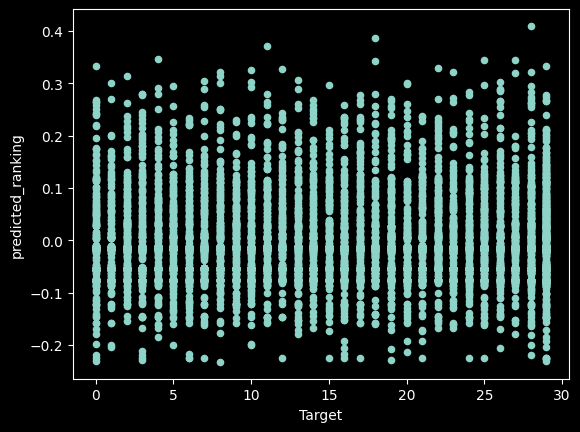

In [80]:
test_df.plot.scatter(x='Target', y='predicted_ranking')